## Class-Specific Dynamic Ensemble Learning (CS-DES)

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pmlb import classification_dataset_names

classification_dataset_names

['GAMETES_Epistasis_2_Way_1000atts_0.4H_EDM_1_EDM_1_1',
 'GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1',
 'GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1',
 'GAMETES_Epistasis_3_Way_20atts_0.2H_EDM_1_1',
 'GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM_2_001',
 'GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM_2_001',
 'Hill_Valley_with_noise',
 'Hill_Valley_without_noise',
 'adult',
 'agaricus_lepiota',
 'allbp',
 'allhyper',
 'allhypo',
 'allrep',
 'analcatdata_aids',
 'analcatdata_asbestos',
 'analcatdata_authorship',
 'analcatdata_bankruptcy',
 'analcatdata_boxing1',
 'analcatdata_boxing2',
 'analcatdata_creditscore',
 'analcatdata_cyyoung8092',
 'analcatdata_cyyoung9302',
 'analcatdata_dmft',
 'analcatdata_fraud',
 'analcatdata_germangss',
 'analcatdata_happiness',
 'analcatdata_japansolvent',
 'analcatdata_lawsuit',
 'ann_thyroid',
 'appendicitis',
 'australian',
 'auto',
 'backache',
 'balance_scale',
 'biomed',
 'breast',
 'breast_cancer',
 'breast_cancer_wisconsin',
 'br

In [3]:
from pmlb import fetch_data
from sklearn.preprocessing import LabelEncoder  

# Returns NumPy arrays
data = fetch_data('led24', return_X_y=False, local_cache_dir='./')

X = data.drop(['target'], axis=1) 
y = data.target

le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)   
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.30, random_state=42)      

In [5]:
train_data = X_train[:]
train_data['target'] = y_train 

n_classes = train_data.target.nunique()

train_data.target.unique(), n_classes

(array([6, 0, 4, 2, 7, 3, 5, 1, 9, 8]), 10)

### Pool of classifiers 

In [6]:
from collections import namedtuple
from random import choices, randint, randrange, random, sample
from typing import List, Callable, Tuple 
from functools import partial


BaseClassifier = namedtuple('BaseClassifier', ['name', 'model', 'classes']) 

pool = [
  
    BaseClassifier('LR', LogisticRegression(random_state=42),                            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 4, 5, 6, 8, 9]), 
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 2, 3, 8]),
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [1, 3, 4, 7, 9]),
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 2, 3, 5, 8]),
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 1, 2, 3, 4, 5, 7, 9]), 
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 1, 3, 7, 8, 9]),
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [2, 4, 5, 6, 7, 8]), 
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [3, 5, 6, 9]), 
    BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 2, 3, 6, 8, 9]), 
    
]

In [7]:
def train(train_data, pool): 
    for bc in pool: 
        partial_train_data = train_data[train_data.target.isin(bc.classes)] 
        X = partial_train_data.drop(['target'], axis=1) 
        y = partial_train_data['target'] 

        bc.model.fit(X, y)
    return pool 

In [8]:
pool = train(train_data, pool)

### Get RoC 

In [9]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k, metric='minkowski').fit(X_dsel)  

In [10]:
def get_region_of_competence(nbrs, query): 
    indices = nbrs.kneighbors(query, return_distance=False)
    roc = X_dsel.iloc[indices[0]]
    roc_labels = y_dsel[indices[0]]

    print(indices)

    return roc, roc_labels 

In [11]:
index = 14
test_sample = X_test.iloc[[index]]

roc, roc_labels = get_region_of_competence(nbrs, test_sample)

y_test[index]

[[712 607 113 103 271 319 263 651 593 578]]


3

In [12]:
unique_labels = list(np.unique(roc_labels)) 

np.isin(unique_labels, [0, 1, 2, 3, 4, 5, 6, 7, 9]).all()

False

In [13]:
unique_labels

[0, 2, 3, 6, 8, 9]

In [14]:
roc_labels

array([2, 0, 8, 2, 9, 3, 3, 6, 3, 8])

In [15]:
votes = {}

for i in range(n_classes): 
    votes[i] = 0 

for bc in pool:
    roc_unique_labels = list(np.unique(roc_labels)) 

    if np.isin(roc_unique_labels, bc.classes).all() == False:  
        continue 
        
    region_classes = np.unique(roc_labels)  
    
    pred = bc.model.predict(roc) 
    acc = accuracy_score(roc_labels, pred)
    
    test_pred = bc.model.predict(test_sample) 
    test_prob = bc.model.predict_proba(test_sample) 
    test_prob = round(test_prob.max(), 2) 
    
    print (pred, round(acc, 3), test_pred, test_prob,  bc.classes)

    votes[test_pred[0]] += (acc * test_prob) 

[6 0 8 2 9 3 3 6 3 8] 0.9 [2] 0.45 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3 0 8 2 9 3 3 6 3 8] 0.9 [3] 0.39 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3 0 8 2 9 3 3 3 3 8] 0.8 [3] 0.47 [0, 2, 3, 6, 8, 9]


In [16]:
votes

{0: 0,
 1: 0,
 2: 0.405,
 3: 0.7270000000000001,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0}

In [17]:
max(votes, key=votes.get) 

3

### Merge 

In [18]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k, metric='minkowski').fit(X_dsel)  

def get_region_of_competence(nbrs, query): 
    indices = nbrs.kneighbors(query, return_distance=False)
    roc = X_dsel.iloc[indices[0]]
    roc_labels = y_dsel[indices[0]]

    return roc, roc_labels 

test_preds = [] 

for j in tqdm(range(len(y_test))): 
    index = j
    test_sample = X_test.iloc[[index]]
    
    roc, roc_labels = get_region_of_competence(nbrs, test_sample)

    votes = {}

    for i in range(n_classes): 
        votes[i] = 0 
    
    for bc in pool:
        roc_unique_labels = list(np.unique(roc_labels)) 

        if np.isin(roc_unique_labels, bc.classes).all() == False:  
            continue 
            
        pred = bc.model.predict(roc) 
        acc = accuracy_score(roc_labels, pred)
        test_pred = bc.model.predict(test_sample) 
        test_prob = bc.model.predict_proba(test_sample) 
        test_prob = test_prob.max()
        
        votes[test_pred[0]] += (acc * test_prob) 

    
    final = max(votes, key=votes.get)  

    test_preds.append(final)

100%|█████████████████████████████████████████| 800/800 [00:26<00:00, 30.76it/s]


In [19]:
accuracy_score(y_test, test_preds)

0.69875

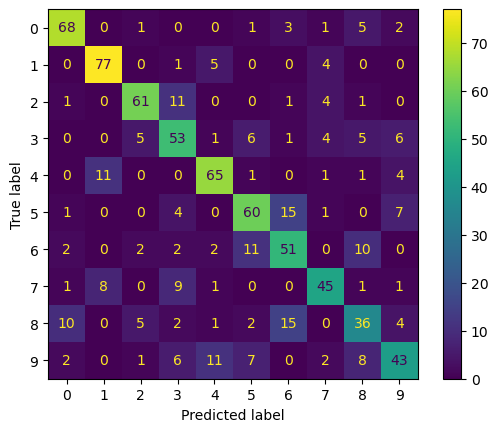

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_test, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=votes.keys())
disp.plot()

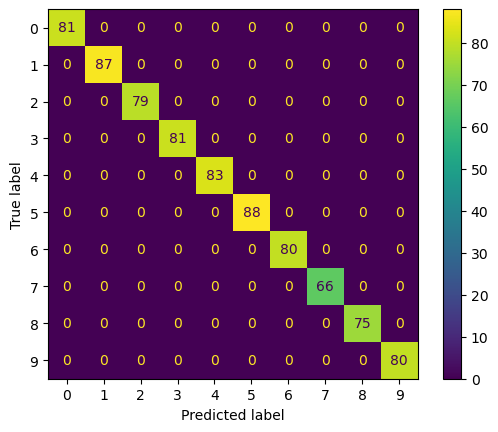

In [21]:
cm = confusion_matrix(y_test, y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=votes.keys())
disp.plot()

### Compare 

In [22]:
pool_classifiers = [
    XGBClassifier(random_state=42),  # 0 
    MLPClassifier(random_state=42),  # 1 
    KNeighborsClassifier(),          # 2 
    RandomForestClassifier(random_state=42),  # 3 
    LogisticRegression(random_state=42),      # 4 
    SVC(probability=True, random_state=42),   # 5 
    # DecisionTreeClassifier(random_state=42),  # 6 
    LGBMClassifier(random_state=42, verbose=-1), # 7  
]

In [23]:
for cls in pool_classifiers: 
    cls.fit(X_train, y_train)

In [24]:
for cls in pool_classifiers: 
    acc = cls.score(X_test, y_test) 
    print(cls, acc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) 0.6525
MLPClassifier(random_state=42) 0.69125
KNeighborsClassifier() 0.54625
RandomForestClassifier(random_state=42) 0.6825
LogisticRegression(random_state=42) 0.7025
SVC(probability=True, random_state=42) 0.69
LGBMClassifier(random_

In [25]:
from deslib.des.knora_e import KNORAE 

knorae = KNORAE(pool_classifiers, k=10, knn_metric='minkowski')

# Preprocess the Dynamic Selection dataset (DSEL)
knorae.fit(X_dsel, y_dsel)

# Predict new examples:
accuracy = knorae.score(X_test, y_test)
print(f'Accuracy: {accuracy:.5f}') 

Accuracy: 0.67875


In [26]:
from deslib.des.meta_des import METADES 

metades = METADES(pool_classifiers, k=10, knn_metric='minkowski')

# Preprocess the Dynamic Selection dataset (DSEL)
metades.fit(X_dsel, y_dsel)

# Predict new examples:
accuracy = metades.score(X_test, y_test)
print(f'Accuracy: {accuracy:.5f}') 

Accuracy: 0.68000


In [27]:
from deslib.des.knop import KNOP 

knop = KNOP(pool_classifiers, k=10)

# Preprocess the Dynamic Selection dataset (DSEL)
knop.fit(X_dsel, y_dsel)

# Predict new examples:
accuracy = knop.score(X_test, y_test)
print(f'Accuracy: {accuracy:.5f}') 

Accuracy: 0.69375


In [28]:
from deslib.des.knora_u import KNORAU 

knop = KNOP(pool_classifiers, k=10)

# Preprocess the Dynamic Selection dataset (DSEL)
knop.fit(X_dsel, y_dsel)

# Predict new examples:
accuracy = knop.score(X_test, y_test)
print(f'Accuracy: {accuracy:.5f}') 

Accuracy: 0.69375


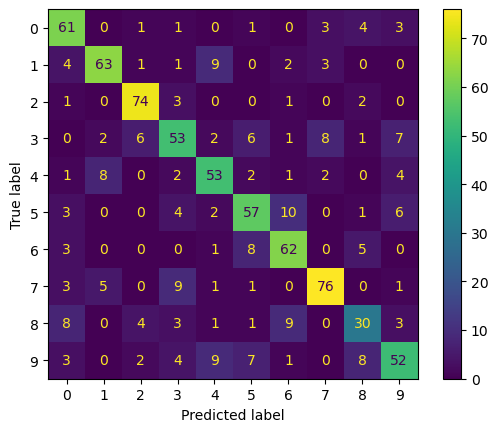

In [407]:
y_pred = knop.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=votes.keys())
disp.plot()

### Benchmark 

In [29]:
from pmlb import fetch_data
from sklearn.preprocessing import LabelEncoder  

# Returns NumPy arrays
data = fetch_data('led24', return_X_y=False, local_cache_dir='./')

X = data.drop(['target'], axis=1) 
y = data.target

le = LabelEncoder()
y = le.fit_transform(y)

In [30]:
seeds = [10, 42, 45, 52, 56, 72, 84, 91, 93, 99] 

BaseClassifier = namedtuple('BaseClassifier', ['name', 'model', 'classes']) 

In [31]:
def get_region_of_competence(nbrs, query): 
    indices = nbrs.kneighbors(query, return_distance=False)
    roc = X_dsel.iloc[indices[0]]
    roc_labels = y_dsel[indices[0]]

    return roc, roc_labels


def train(train_data, pool): 
    for bc in pool: 
        partial_train_data = train_data[train_data.target.isin(bc.classes)] 
        X = partial_train_data.drop(['target'], axis=1) 
        y = partial_train_data['target'] 

        bc.model.fit(X, y)

    return pool 

In [37]:
benchmark_scores = []

for seed in seeds: 
    pool = [
        BaseClassifier('LR', LogisticRegression(random_state=42),                            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
        
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 4, 5, 6, 8, 9]), 
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 2, 3, 8]),
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [1, 3, 4, 7, 9]),
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 2, 3, 5, 8]),
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [0, 1, 3, 7, 8, 9]),
        BaseClassifier('RF', RandomForestClassifier(random_state=42),                        [3, 5, 6, 9]), 
    ] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)   
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.30, random_state=42)  

    k = 10
    nbrs = NearestNeighbors(n_neighbors=k, metric='minkowski').fit(X_dsel) 

    train_data = X_train[:]
    train_data['target'] = y_train 
    
    pool = train(train_data, pool) 
    
    test_preds = []  

    for j in tqdm(range(len(y_test))): 
        index = j
        test_sample = X_test.iloc[[index]] 

        roc, roc_labels = get_region_of_competence(nbrs, test_sample)

        votes = {}
    
        for i in range(n_classes): 
            votes[i] = 0 
        
        for bc in pool:
            roc_unique_labels = list(np.unique(roc_labels)) 
    
            if np.isin(roc_unique_labels, bc.classes).all() == False:  
                continue 
                
            pred = bc.model.predict(roc) 
            acc = accuracy_score(roc_labels, pred)
            test_pred = bc.model.predict(test_sample) 
            test_prob = bc.model.predict_proba(test_sample) 
            test_prob = test_prob.max()
            
            votes[test_pred[0]] += (acc * test_prob) 
    
        
        final_prediction = max(votes, key=votes.get)  
    
        test_preds.append(final_prediction)

    # Score 
    accuracy = accuracy_score(y_test, test_preds) 

    benchmark_scores.append(accuracy)

100%|█████████████████████████████████████████| 800/800 [00:19<00:00, 40.90it/s]


In [38]:
benchmark_scores

[0.72125,
 0.7325,
 0.74125,
 0.725,
 0.74125,
 0.73375,
 0.7425,
 0.72875,
 0.71875,
 0.6975]

In [34]:
from deslib.des.knora_e import KNORAE  
from deslib.des.knora_u import KNORAU 
from deslib.des.knop import KNOP  
from deslib.des.meta_des import METADES 
from deslib.des.des_knn import DESKNN 

benchmark_matrix = {
    "knorae": [], 
    "knorau": [], 
    "metades": [], 
    "knop": [], 
    "desknn": []
}


for seed in tqdm(seeds): 
    pool_classifiers = [
        XGBClassifier(random_state=42),  # 0 
        MLPClassifier(random_state=42),  # 1 
        KNeighborsClassifier(),          # 2 
        RandomForestClassifier(random_state=42),  # 3 
        LogisticRegression(random_state=42),      # 4 
        SVC(probability=True, random_state=42),   # 5 
        DecisionTreeClassifier(random_state=42),  # 6 
        LGBMClassifier(random_state=42, verbose=-1), # 7  
    ] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)   
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.30, random_state=42) 

    for cls in pool_classifiers: 
        cls.fit(X_train, y_train)

    knorae = KNORAE(pool_classifiers, k=10, knn_metric='minkowski')
    knorau = KNORAU(pool_classifiers, k=10, knn_metric='minkowski')
    metades = METADES(pool_classifiers, k=10, knn_metric='minkowski')
    knop = KNOP(pool_classifiers, k=10) 
    desknn = DESKNN(pool_classifiers, k=10, knn_metric='minkowski')
    
    # Preprocess the Dynamic Selection dataset (DSEL)
    knorae.fit(X_dsel, y_dsel)
    knorau.fit(X_dsel, y_dsel)
    metades.fit(X_dsel, y_dsel)
    knop.fit(X_dsel, y_dsel)
    desknn.fit(X_dsel, y_dsel)
    
    # Predict new examples:
    benchmark_matrix['knorae'].append(knorae.score(X_test, y_test))
    benchmark_matrix['knorau'].append(knorau.score(X_test, y_test))
    benchmark_matrix['metades'].append(metades.score(X_test, y_test))
    benchmark_matrix['knop'].append(knop.score(X_test, y_test))
    benchmark_matrix['desknn'].append(desknn.score(X_test, y_test))

100%|███████████████████████████████████████████| 10/10 [01:22<00:00,  8.29s/it]


In [39]:
np.average(benchmark_scores)

0.72825

In [36]:
techniques = ['knorae', 'knorau', 'knop', 'metades', 'desknn'] 

for tech in techniques: 
    print(tech, round(np.average(benchmark_matrix[tech]), 3) )

knorae 0.707
knorau 0.724
knop 0.726
metades 0.711
desknn 0.721
